In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'

from os.path import join, exists
from os import mkdir
import json

from braket.aws import AwsDevice, AwsQuantumTask
import braket.ahs
import braket.ir.ahs
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.timings.time_series import TimeSeries
from braket.ahs.field import Field
from braket.ahs.driving_field import DrivingField
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator


In [2]:
use_local_simulator = True

# Query the Aquila QPU
if use_local_simulator:
    device = LocalSimulator("braket_ahs")
else:
    device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
print(device.name)


# Query the Aquila QPU
aquila_qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Extract parameter ranges
C6 = aquila_qpu.properties.paradigm.rydberg.c6Coefficient
omega_min, omega_max = aquila_qpu.properties.paradigm.rydberg.rydbergGlobal.rabiFrequencyRange
omega_slope_max = aquila_qpu.properties.paradigm.rydberg.rydbergGlobal.rabiFrequencySlewRateMax
global_delta_min, global_delta_max = aquila_qpu.properties.paradigm.rydberg.rydbergGlobal.detuningRange
delta_min = float(global_delta_min)
delta_max = float(global_delta_max)

time_max = aquila_qpu.properties.paradigm.rydberg.rydbergGlobal.timeMax
# local_delta_min, local_delta_max = aquila_qpu.properties.paradigm.rydberg.rydbergLocal.detuningRange
spatial_vertical_min = aquila_qpu.properties.paradigm.lattice.geometry.spacingVerticalMin
minimum_ramp_time = (omega_max - omega_min) / omega_slope_max
time_delta_min = aquila_qpu.properties.paradigm.rydberg.rydbergGlobal.timeDeltaMin
width = aquila_qpu.properties.paradigm.lattice.area.width
height = aquila_qpu.properties.paradigm.lattice.area.height

position_resolution = aquila_qpu.properties.paradigm.lattice.geometry.positionResolution
time_resolution = aquila_qpu.properties.paradigm.rydberg.rydbergGlobal.timeResolution
rabi_frequency_resolution = aquila_qpu.properties.paradigm.rydberg.rydbergGlobal.rabiFrequencyResolution
detuning_resolution = aquila_qpu.properties.paradigm.rydberg.rydbergGlobal.detuningResolution

RydbergAtomSimulator


In [3]:
def get_codewords(n):
    # Input: n = int, number of qubits
    # Output: C = [np.array] list of code words as numpy arrays for 1D chain
    C = []
    # get the first code word
    bitstring = np.array([k % 2 for k in range(n)], dtype=int)
    
    
    for k in range(n+1):
        C.append(np.copy(bitstring))
        if k < n:
            bitstring[k] = 1 - bitstring[k]
        
    return C

def get_atom_positions(n, d1, d2, d3):
    atom_positions = []
    for i in range(2):
        for j in range(n):
            if i == 0:
                atom_positions.append((i*d2, j*d1))
            else:
                atom_positions.append((i*d2, d3 + j*d1))
            
    return atom_positions


def compute_Z_energy(w, Delta, C6, atom_positions):
    # Input: w = concatenated vector with k code word strings each with the same length
    # Output: E = energy in the "Z" part of the Rydberg Hamiltonian
    
    n = len(w)
    E = 0
    
    # 1-qubit n: - Delta * sum_j n_j
    E -= Delta * np.sum(w)
    
    # 2-qubit n: + sum_{j,k} C6/d^6_{j,k} * njnk
    V = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            V[i,j] = C6 / np.linalg.norm(np.array(atom_positions)[i] - np.array(atom_positions)[j]) ** 6
    
    E += w @ V @ w
    
    return E

In [4]:
def init_register(atom_positions):
    # atom_positions = list[tuple]
    register = AtomArrangement()
    for v in atom_positions:
        register.add(v)
    return register


def show_register(register):
    filled_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.FILLED]
    empty_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.VACANT]
    fig = plt.figure(figsize=(7, 7))
    if len(filled_sites) > 0:
        plt.plot(np.array(filled_sites)[:, 0], np.array(filled_sites)[:, 1], 'r.', ms=15, label='filled')
    if len(empty_sites) > 0:
        plt.plot(np.array(empty_sites)[:, 0], np.array(empty_sites)[:, 1], '.', color='k', ms=2, label='vacant')
    plt.legend(bbox_to_anchor=(1.1, 1.05))


def show_global_drive(drive):
    data = {
        'amplitude [rad/s]': drive.amplitude.time_series,
        'detuning [rad/s]': drive.detuning.time_series,
        'phase [rad]': drive.phase.time_series,
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
    for ax, data_name in zip(axes, data.keys()):
        if data_name == 'phase [rad]':
            ax.step(data[data_name].times(), data[data_name].values(), '.-', where='post')
        else:
            ax.plot(data[data_name].times(), data[data_name].values(), '.-')
        ax.set_ylabel(data_name)
        ax.grid(ls=':')
    axes[-1].set_xlabel('time [s]')
    plt.tight_layout()

def get_index_on_chain(n : int, bitstring):
    # Returns the index on the chain, or -1 if not in the low energy subspace
    
    flips = 0
    
    # first index k where bits at indices k and k+1 are the same
    first_ferromagnetic_index = None
    for k in range(n-1):
        if bitstring[k] != bitstring[k+1]:
            flips += 1
        elif first_ferromagnetic_index is None:
            first_ferromagnetic_index = k
    
    if flips < n - 2 or (bitstring[0] == 0 and flips == n - 2):
        return -1
    else:
        if flips == n - 1:
            if bitstring[0] == 0:
                return 0
            else:
                return n
        if flips == n - 2:
            return first_ferromagnetic_index + 1
        
        

def decoder_2d(n:int, measurements, num_shots:int, use_json_format:bool):
    # Input: raw measurement results from the QuEra machine/simulator
    # Output: occurrences: frequency count of the measurement interpreted as a sample over 2D lattice
    #         bad_samples: number of bad_samples (missing atoms in the pre sequence)
    occurrences = np.zeros((n+1,n+1), dtype=int)
    bad_samples = 0
    for i in range(num_shots):
        if use_json_format:
            bitstring = 1 - measurements[i]["shotResult"]["postSequence"]
        else:
            bitstring = 1 - measurements[i].post_sequence
        
        # decoding 2D measurement data
        if use_json_format:
            flag = np.prod(measurements[i]["shotResult"]["preSequence"][0:2*n])
        else:
            flag = np.prod(measurements[i].pre_sequence[0:2*n])

        if flag > 0:
            index_x = get_index_on_chain(n, bitstring[0:n])
            index_y = get_index_on_chain(n, bitstring[n:2*n])
            
            if index_x >=0 and index_y >= 0:
                occurrences[index_x, index_y] += 1
        else:
            bad_samples += 1
        
    print(f"Bad samples (missing atoms): {bad_samples}")
    print(f"Samples in codeword subspace: {np.sum(occurrences)} out of {num_shots - bad_samples}")
    return occurrences, bad_samples


# returns minimum distance for n atoms on a chain
def get_min_distance_chain(global_delta):
    # minimum distance due to minimum y-distance
    R1 = float(spatial_vertical_min)
    # minimum distance due to maximum global detuning
    R2 = (float(C6) / global_delta) ** (1/6)
    return max(R1, R2)

def tv_dist(dist_1, dist_2):
    return 0.5 * np.sum(np.abs(dist_1 - dist_2))

# compute tv dist to subspace spanned by ground state and first excited state
def tv_dist_to_subspace(dist, ground_state, first_excited_state):
    tv_distance = []
    for alpha in np.linspace(0, 1):
        psi = alpha * ground_state + (1 - alpha ** 2) * first_excited_state
        tv_distance.append(tv_dist(dist, np.abs(psi) ** 2))

    return np.min(tv_distance)

Distance between atoms along a single chain:  5.9e-06
Distance between chains:  8.8e-06
Vertical offset between chains:  0.0


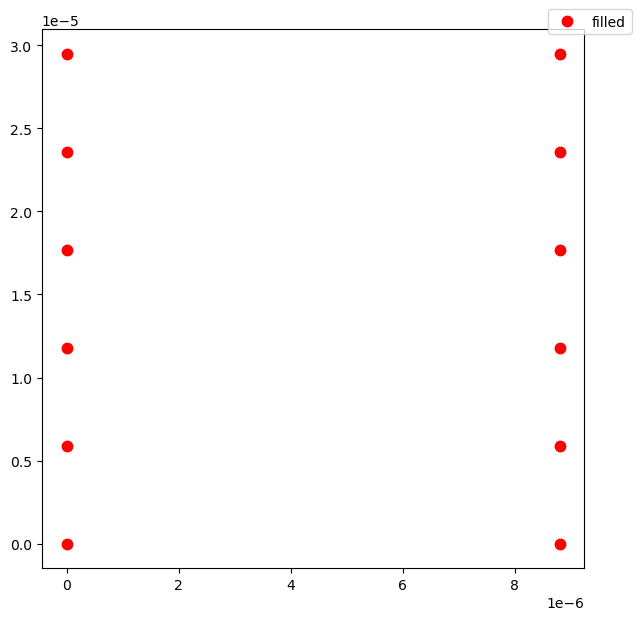

In [5]:
n = 6

d1 = round(get_min_distance_chain(delta_max) / float(position_resolution)) * float(position_resolution)
print(f"Distance between atoms along a single chain: {d1 : 0.3}")
d2 = round(1.5 * d1 / float(position_resolution)) * float(position_resolution)
print(f"Distance between chains: {d2 : 0.3}")
d3 = 0.0
print(f"Vertical offset between chains: {d3 : 0.3}")

C6 = float(C6)
omega_max = float(omega_max)

atom_positions = get_atom_positions(n, d1, d2, d3)
register = init_register(atom_positions)
show_register(register)

In [6]:
def initial_state_prep(register, num_shots, T, alpha, beta):

    amplitude = TimeSeries()
    amplitude.put(0.0, 0)
    amplitude.put(T/3, alpha*omega_max)
    amplitude.put(2*T/3, alpha*omega_max)
    amplitude.put(T, 0)

    global_detuning = TimeSeries()
    global_detuning.put(0.0, beta*delta_min)
    global_detuning.put(T, beta*delta_max)

    phase = TimeSeries()
    phase.put(0.0, 0)
    phase.put(T, np.pi)

    drive = DrivingField(
            amplitude=amplitude, 
            detuning=global_detuning, 
            phase=phase
        )
    
    ahs_program = AnalogHamiltonianSimulation(
        register=register, 
        hamiltonian=drive
    )

    #show_global_drive(drive)
    #plt.show()

    # submit task to local simulator
    discretized_ahs_program = ahs_program.discretize(aquila_qpu)
    task = device.run(discretized_ahs_program, shots=num_shots)
    
    return drive, task

In [7]:
def ground_state_prep(register, num_shots, T_init, T_full, alpha, beta, gamma1, gamma2):
    omega_ramp_time = 100e-9
    
    assert T_full > T_init + 2*omega_ramp_time
    
    amplitude = TimeSeries()
    # initial state prep
    amplitude.put(0.0, 0)
    amplitude.put(T_init/3, alpha*omega_max)
    amplitude.put(2*T_init/3, alpha*omega_max)
    amplitude.put(T_init, 0)
    # ground state prep
    amplitude.put(T_init + omega_ramp_time, gamma1*omega_max)
    b = -0.2 * (gamma2 * omega_max - gamma1 * omega_max) / (gamma2 * omega_max * (T_full - omega_ramp_time) ** 2 - gamma1 * omega_max * (T_init + omega_ramp_time) ** 2)
    a = gamma1 * omega_max * (0.2 + b * (T_init + omega_ramp_time) ** 2)
    amplitude.put(2 * (T_init + omega_ramp_time) / 3 + (T_full - omega_ramp_time) / 3, a / (0.2 + b * (2 * (T_init + omega_ramp_time) / 3 + (T_full - omega_ramp_time) / 3) ** 2))
    amplitude.put((T_init + omega_ramp_time) / 3 + 2 * (T_full - omega_ramp_time) / 3, a / (0.2 + b * ((T_init + omega_ramp_time) / 3 + 2 * (T_full - omega_ramp_time) / 3) ** 2))
    amplitude.put(T_full - omega_ramp_time, gamma2*omega_max)
    amplitude.put(T_full, 0)

    global_detuning = TimeSeries()
    # initial state prep
    global_detuning.put(0.0, beta*delta_min)
    global_detuning.put(T_init, beta*delta_max)
    # ground state prep
    global_detuning.put(T_full, beta*delta_max)

    phase = TimeSeries()
    phase.put(0.0, 0)
    phase.put(T_init, np.pi)
    phase.put(T_full, np.pi)
        
    drive = DrivingField(
            amplitude=amplitude, 
            detuning=global_detuning, 
            phase=phase
        )
    
    ahs_program = AnalogHamiltonianSimulation(
        register=register, 
        hamiltonian=drive
    )

    #show_global_drive(drive)
    #plt.show()

    # submit task to local simulator
    discretized_ahs_program = ahs_program.discretize(aquila_qpu)
    task = device.run(discretized_ahs_program, shots=num_shots)
    
    return drive, task

## The effective 2D potential field

In [8]:
C = get_codewords(n)

gamma2 = 0.8
beta = 0.4
final_omega = gamma2 * omega_max
final_delta = beta * delta_max

D = np.zeros((n+1,n+1))
I = np.eye(n+1)
for j in range(n):
    D[j,j+1] = D[j+1,j] = 1
A = np.kron(D,I) + np.kron(I,D)

F = np.zeros((n+1,n+1), dtype=float)
for i in range(n + 1):
    for j in range(n + 1):
        F[i,j] = compute_Z_energy(np.concatenate([C[i], C[j]]), final_delta * 1e-6, C6 * 1e30, np.array(atom_positions) * 1e6)

F -= np.min(F)

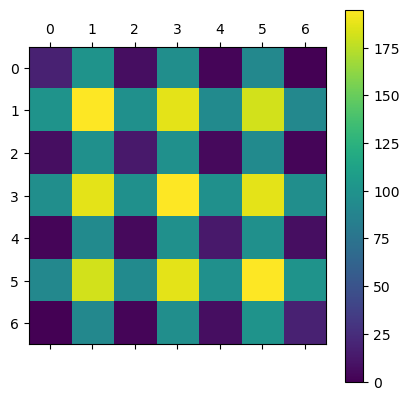

In [9]:
plt.matshow(F)
plt.colorbar()
plt.show()

## Initial state preparation

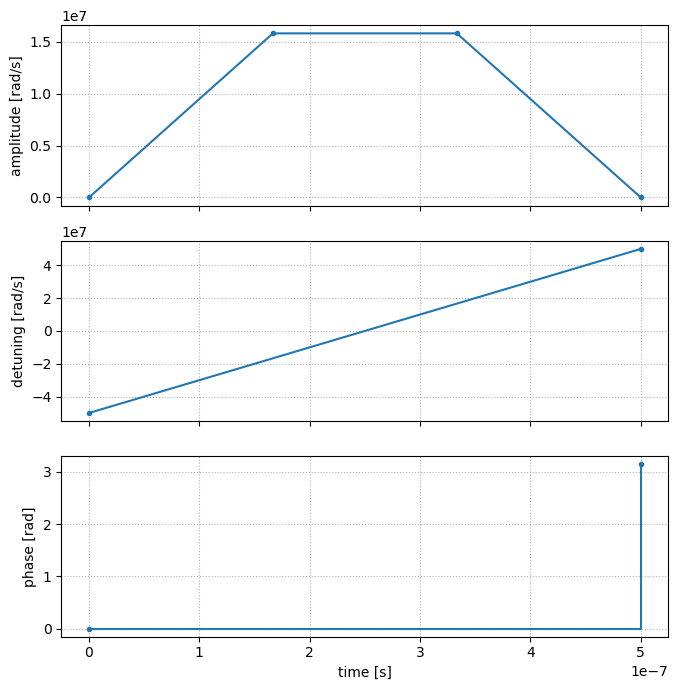

Bad samples (missing atoms): 0
Samples in codeword subspace: 706 out of 1000


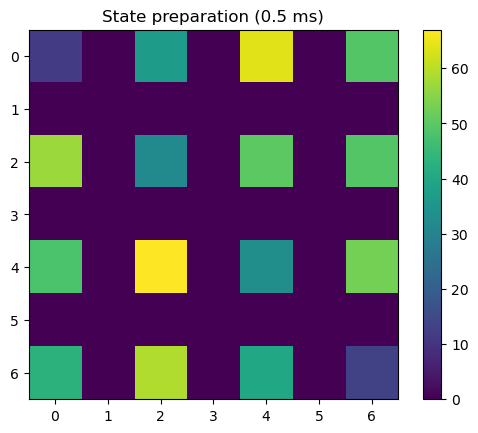

Average Z energy: 5.539544221108842


In [13]:
n = 6
num_shots = 1000

alpha = 1
beta = 0.4
T_state_prep = 0.5e-6
drive, task = initial_state_prep(register, num_shots, T_state_prep, alpha, beta)

# print drive pulses
show_global_drive(drive)
plt.show()
# show the final states/occurrences
result = task.result()
occurrences, bad_samples = decoder_2d(n, result.measurements, num_shots=num_shots, use_json_format=False)
plt.imshow(occurrences)
plt.title("State preparation (0.5 ms)")
plt.colorbar()
plt.show()

dist = occurrences / np.sum(occurrences)
initial_energy = np.sum(dist * F)
print(f"Average Z energy: {initial_energy}")

T_full = 1e-06 s
Bad samples (missing atoms): 0
Samples in codeword subspace: 503 out of 1000
Average Z energy: 4.232706281443178

T_full = 1.5e-06 s
Bad samples (missing atoms): 0
Samples in codeword subspace: 602 out of 1000
Average Z energy: 3.834242925804526

T_full = 2e-06 s
Bad samples (missing atoms): 0
Samples in codeword subspace: 582 out of 1000
Average Z energy: 3.758223262464976



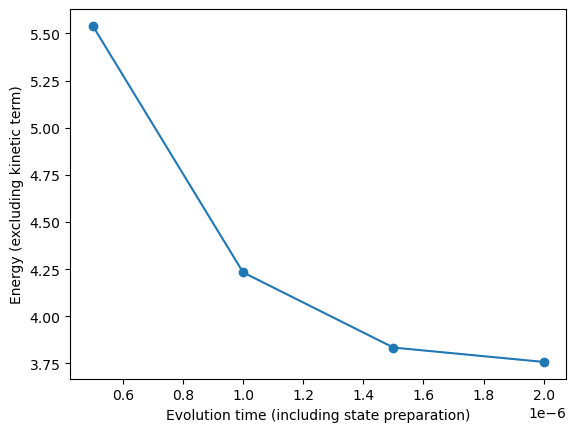

In [37]:
num_shots = 1000
T_init = 0.5e-6
sim_end_times = [1e-6, 1.5e-6, 2.0e-6]
alpha = 1.0
beta = 0.4
gamma1 = 1.0
gamma2 = 0.1
energy_vals = []

sim_dists = []
for idx in range(len(sim_end_times)):
    T_full = sim_end_times[idx]
    print(f"T_full = {T_full} s")
    
    if use_local_simulator:
        drive, task = ground_state_prep(register, num_shots, T_init, T_full, alpha, beta, gamma1, gamma2)
        
        # print drive pulses
        # show_global_drive(drive)
        # plt.show()
        
        result = task.result()
        occurrences, bad_samples = decoder_2d(n, result.measurements, num_shots=num_shots, use_json_format=False)
        # plt.matshow(occurrences)
        # plt.title(f"Ground state preparation ({T_full*1e6:.1f} ms)")
        # plt.colorbar()
        # plt.show()
        
        dist = occurrences / np.sum(occurrences)
        sim_dists.append(dist)
        Z_energy = np.sum(dist * F)
        print(f"Average Z energy: {Z_energy}")
        energy_vals.append(Z_energy)
    print()

plt.plot([T_init] + sim_end_times, [initial_energy] + energy_vals, "-o")
plt.xlabel("Evolution time (including state preparation)")
plt.ylabel("Energy (excluding kinetic term)")
plt.show()

In [15]:
np.savez("2d_sim_data.npz", sim_times=[T_init] + sim_end_times, sim_energy=[initial_energy] + energy_vals)

# Submit tasks to QuEra

In [28]:
use_local_simulator = False

# Query the Aquila QPU
if use_local_simulator:
    device = LocalSimulator("braket_ahs")
else:
    device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
print(device.name)

# Query the Aquila QPU
aquila_qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

Aquila


In [29]:
# Task 1: initial state preparation
num_shots = 1000
T_init = 0.5e-6
alpha = 1.0
beta = 0.4

# Cost estimation
num_measurement_times = 1
print("Cost on real machine:", (1 + num_measurement_times) * (num_shots * 0.01 + 0.3))
print(f"Estimated time (minutes): {num_shots * (1 + num_measurement_times) / (2.5 * 60): 0.2f}")

Cost on real machine: 20.6
Estimated time (minutes):  13.33


In [30]:
if use_local_simulator:
    drive, task = initial_state_prep(register, num_shots, T_init, alpha, beta)
    result = task.result()
    occurrences, bad_samples = decoder_2d(n, result.measurements, num_shots=num_shots, use_json_format=False)
    plt.imshow(occurrences)
    plt.title(f"Initial state preparation ({T_init*1e6:.1f} ms)")
    plt.colorbar()

else:
    drive, task = initial_state_prep(register, num_shots, T_init, alpha, beta)
    metadata = task.metadata()
    task_arn = metadata['quantumTaskArn']
    print(f"Initial state prep - TASK ARN: {task_arn}")


Initial state prep - TASK ARN: arn:aws:braket:us-east-1:795824654075:quantum-task/1ad19933-09c0-4368-9b34-ea08dd2ef687


In [19]:
# Ground state preparation at 1, 1.5, 2 micseconds
num_shots = 1000
T_init = 0.5e-6
quera_end_times = [1e-6, 1.5e-6, 2e-6]
alpha = 1.0
beta = 0.4
gamma1 = 1.0
gamma2 = 0.1
task_arns = []

# Cost estimation
num_measurement_times = len(quera_end_times)
print("Cost on real machine:", (1 + num_measurement_times) * (num_shots * 0.01 + 0.3))
print(f"Estimated time (minutes): {num_shots * (1 + num_measurement_times) / (2.5 * 60): 0.2f}")

Cost on real machine: 41.2
Estimated time (minutes):  26.67


In [45]:
for idx in range(len(quera_end_times)):
    T_full = quera_end_times[idx]
    print(f"Total evolution time: {T_full*1e6:0.1f} microseconds")
    
    if use_local_simulator:
        drive, task = ground_state_prep(register, num_shots, T_init, T_full, alpha, beta, gamma1, gamma2)
        result = task.result()
        occurrences, bad_samples = decoder_2d(n, result.measurements, num_shots=num_shots, use_json_format=False)
        plt.imshow(occurrences)
        plt.title(f"Ground state preparation ({T_full*1e6:.1f} us)")
        plt.colorbar()
        plt.show()
        # tv_distance = 0.5 * np.sum(np.abs(occurrences/num_shots - target_dist))
        # print(f"T_full = {T_full*1e6:.1f} us, TV distance = {tv_distance:.4f}")

    else:
        drive, task = ground_state_prep(register, num_shots, T_init, T_full, alpha, beta, gamma1, gamma2)
        metadata = task.metadata()
        task_arn = metadata['quantumTaskArn']
        task_arns.append(task_arn)
        print(f"ARN: {task_arn}")
        

Total evolution time: 1.0 microseconds
ARN: arn:aws:braket:us-east-1:795824654075:quantum-task/b26145fe-9f37-4b3f-8855-668085629282
Total evolution time: 1.5 microseconds
ARN: arn:aws:braket:us-east-1:795824654075:quantum-task/d5d6da9a-8e39-4931-a050-f14d6aa5dfc2
Total evolution time: 2.0 microseconds
ARN: arn:aws:braket:us-east-1:795824654075:quantum-task/8e2ca95e-7d4a-4c34-9f6d-f14637bda02a


# Real-machine results

Initial state preparation

Bad samples (missing atoms): 49
Samples in codeword subspace: 570 out of 951


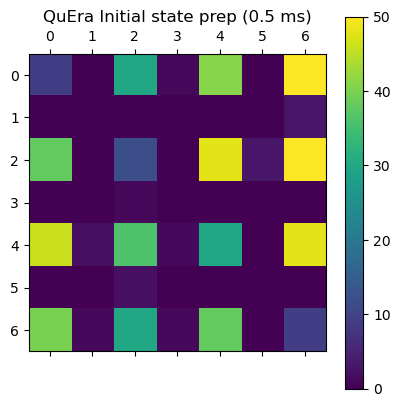

In [24]:
quera_energy = []

task_arn = "arn:aws:braket:us-east-1:795824654075:quantum-task/1ad19933-09c0-4368-9b34-ea08dd2ef687"

task = AwsQuantumTask(arn=task_arn)
result = task.result()
quera_occurrences, bad_samples = decoder_2d(n, result.measurements, num_shots=num_shots, use_json_format=False)
plt.matshow(quera_occurrences)
plt.title(f"QuEra Initial state prep (0.5 ms)")
plt.colorbar()
plt.show()
quera_dist = quera_occurrences / np.sum(quera_occurrences)
quera_energy.append(np.sum(quera_dist * F))

In [79]:
# H = np.load(join("data", "H_subspace.npz"))["H_subspace"]
# eigvals, eigvecs = np.linalg.eigh(H)
# ground_state = eigvecs[:,0].reshape((n+1,n+1))
# first_excited_state = eigvecs[:,1].reshape((n+1,n+1))

# plt.matshow(ground_state)
# plt.colorbar()
# plt.title(f"Ground state")
# plt.show()

# plt.matshow(first_excited_state)
# plt.colorbar()
# plt.title(f"First excited state")
# plt.show()

Ground state preparation

In [30]:
task_arns = [
    "arn:aws:braket:us-east-1:795824654075:quantum-task/b26145fe-9f37-4b3f-8855-668085629282",
    "arn:aws:braket:us-east-1:795824654075:quantum-task/d5d6da9a-8e39-4931-a050-f14d6aa5dfc2",
    "arn:aws:braket:us-east-1:795824654075:quantum-task/8e2ca95e-7d4a-4c34-9f6d-f14637bda02a"
]

Bad samples (missing atoms): 45
Samples in codeword subspace: 449 out of 955


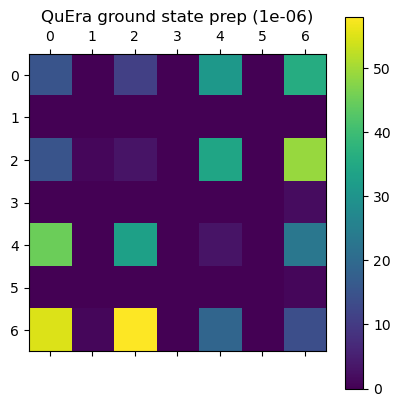

Average Z energy: 5.398623983230044
Bad samples (missing atoms): 47
Samples in codeword subspace: 448 out of 953


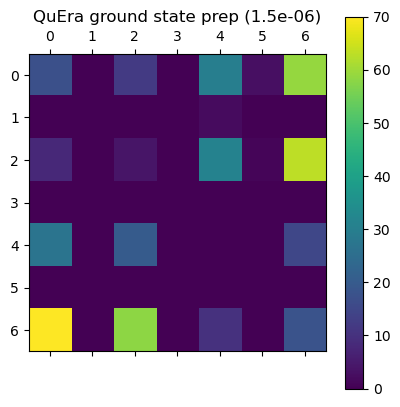

Average Z energy: 5.142237576789878
Bad samples (missing atoms): 53
Samples in codeword subspace: 423 out of 947


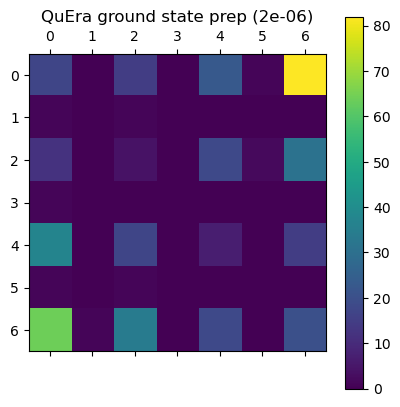

Average Z energy: 6.185099055399517


In [38]:
quera_dists = []

for i in range(len(task_arns)):
    task = AwsQuantumTask(arn=task_arns[i])
    result = task.result()
    quera_occurrences, bad_samples = decoder_2d(n, result.measurements, num_shots=num_shots, use_json_format=False)
    quera_dist = quera_occurrences / np.sum(quera_occurrences)

    quera_dists.append(quera_dist)
    plt.matshow(quera_occurrences)
    plt.title(f"QuEra ground state prep ({quera_end_times[i]})")
    plt.colorbar()
    plt.show()

    # print("TV dist to ground state:", tv_dist(quera_dist, np.abs(ground_state) ** 2))
    # print("TV dist to subspace spanned by ground state and first excited state:", tv_dist_to_subspace(quera_dist, ground_state, first_excited_state))

    # numerical_dist = np.load(join("data", "2d_final_dist_1.0.npy"))
    # print("TV dist to numerical result (restricted to codeword subspace):", tv_dist(quera_dist, numerical_dist))

    Z_energy = np.sum(quera_dist * F)
    print(f"Average Z energy: {Z_energy}")
    quera_energy.append(Z_energy)

In [41]:
np.savez("data.npz",
         sim_end_times=sim_end_times, 
         sim_dists=sim_dists, 
         quera_end_times=quera_end_times,
         quera_dists=quera_dists)

In [32]:
data = np.load("2d_sim_data.npz")

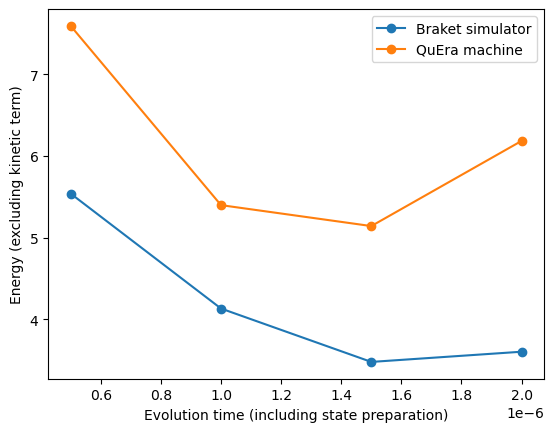

In [34]:
plt.plot(data["sim_times"], data["sim_energy"], "-o", label="Braket simulator")
plt.plot([T_init] + quera_end_times, quera_energy, '-o', label="QuEra machine")
plt.legend()
plt.xlabel("Evolution time (including state preparation)")
plt.ylabel("Energy (excluding kinetic term)")
plt.show()